In [1]:
import jax

jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

import pprint
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.time import Time

from jplephem.spk import SPK

import rebound
import assist
from rebound import Particle as rebound_Particle

from jorbit import Particle
from jorbit.accelerations import (
    create_default_ephemeris_acceleration_func,
    create_newtonian_ephemeris_acceleration_func,
    create_ephem_grav_harmonics_acceleration_func,
    nongrav_acceleration,
)
from jorbit.data.constants import (
    EARTH_J_HARMONICS,
    EARTH_RADIUS,
    SPEED_OF_LIGHT,
    SUN_J_HARMONICS,
    SUN_RADIUS,
)
from jorbit.ephemeris import Ephemeris, EphemerisProcessor
from jorbit.utils.horizons import horizons_bulk_vector_query
from jorbit.utils.states import CartesianState, SystemState, KeplerianState

times = Time(
    np.linspace(Time("2029-01-01").tdb.jd, Time("2030-01-01").tdb.jd, 1000),
    format="jd",
    scale="tdb",
)
ephem = assist.Ephem(
    "/Users/cassese/Downloads/linux_p1550p2650.440", # replace with your path
    "/Users/cassese/Downloads/sb441-n16.bsp",
)

In [2]:
# get the Sun's position and velocity from the usual jorbit interface-
# the Apophis SPK's are relative to the Sun, not the solar system barycenter
usual_eph = Ephemeris(ssos="default solar system")
eph_state = usual_eph.state(times)
sun_xs = eph_state["sun"]["x"].value
sun_vs = eph_state["sun"]["v"].value
earth_xs = eph_state["earth"]["x"].value
earth_vs = eph_state["earth"]["v"].value

def parse_apophis_file(filename):

    # open ephemeris
    spk = SPK.open(filename)
    starts = np.array([seg.start_jd for seg in spk.segments])
    ends = np.array([seg.end_jd for seg in spk.segments])
    order = starts.argsort()
    starts = jnp.array(starts[order])
    ends = jnp.array(ends[order])

    # create a list of EphemerisProcessor objects for each segment
    processors = []
    for ind in order:
        init, intlen, coeff = spk.segments[ind]._data
        processors.append(
            EphemerisProcessor(
                jnp.array([init]), jnp.array([intlen]), jnp.array([coeff]), jnp.array([0.0])
            )
        )

    # figure out which processor to use for each time
    processor_inds = jnp.searchsorted(starts, times.tdb.jd) - 1

    # query those processors for the state of Apophis, then subtract off the sun's position
    helio_xs = np.zeros((len(processor_inds), 3))
    helio_vs = np.zeros((len(processor_inds), 3))
    for i, (ind, t) in enumerate(zip(processor_inds, times.tdb.jd)):
        _x, _v = processors[ind].state(t)
        helio_xs[i] = _x[0]
        helio_vs[i] = _v[0]
    final_xs = helio_xs + sun_xs
    final_vs = helio_vs + sun_vs

    return jnp.array(final_xs), jnp.array(final_vs)

jpl_220_xs, jpl_220_vs = parse_apophis_file("data/sb-99942-220.bsp")
jpl_218_xs, jpl_218_vs = parse_apophis_file("data/sb-99942-218.bsp")

In [3]:
# start at the exact same time
apophis_initial = rebound_Particle(
    x=jpl_220_xs[0, 0],
    y=jpl_220_xs[0, 1],
    z=jpl_220_xs[0, 2],
    vx=jpl_220_vs[0, 0],
    vy=jpl_220_vs[0, 1],
    vz=jpl_220_vs[0, 2],
)


sim = rebound.Simulation()
sim.add(apophis_initial)
sim.t = times[0].tdb.jd - ephem.jd_ref
sim.ri_ias15.min_dt = 0.001
extras = assist.Extras(sim, ephem)

# Turn on GR for star and all planets
extras.gr_eih_sources = 11  

# Add the nongravitational forces (values specific to Apophis from the Horizons solution)
extras.particle_params = np.array([4.999999873689e-13, -2.901085508711e-14, 0.0])

assist_xs = np.zeros((len(times), 3))
assist_vs = np.zeros((len(times), 3))
for i, t in enumerate(times):
    extras.integrate_or_interpolate(t.tdb.jd - ephem.jd_ref)
    assist_xs[i] = sim.particles[0].xyz
    assist_vs[i] = sim.particles[0].vxyz


In [4]:
# construct each component of the acceleration function piece-by-piece

# first, just the usual gravitational acceleration function, GR for planets, newtonian for asteroids
eph = Ephemeris(ssos="default solar system")
acc_func_grav = create_default_ephemeris_acceleration_func(
    ephem_processor=eph.processor
)

# add the J harmonics for the Sun and Earth
acc_func_solar_harmonics = create_ephem_grav_harmonics_acceleration_func(
    eph.processor, ephem_index=0, state_index=0
)
acc_func_earth_harmonics = create_ephem_grav_harmonics_acceleration_func(
    eph.processor, ephem_index=3, state_index=1
)

# combine those 3, along with the non-gravitational forces
# (which didn't need to be created separately since it just relies on SystemState)
def _acc_func(state: SystemState) -> jnp.ndarray:
    return (
        acc_func_grav(state)
        + nongrav_acceleration(state)
        + acc_func_solar_harmonics(state)
        + acc_func_earth_harmonics(state)
    )
acc_func = jax.tree_util.Partial(_acc_func)

# set the J coefficients
js = jnp.zeros((2, 3))
js = js.at[0,0].set(SUN_J_HARMONICS[0])
js = js.at[1].set(EARTH_J_HARMONICS)

acceleration_func_kwargs={
        "c2": SPEED_OF_LIGHT**2,
        "a1": jnp.array([4.999999873689e-13]), # the same non-grav coefficients
        "a2": jnp.array([-2.901085508711e-14]),
        "a3": jnp.array([0.0]),
        "js_req": jnp.array([SUN_RADIUS, EARTH_RADIUS]),
        "js_pole_ra": jnp.array([286.13*jnp.pi/180, 359.99868*jnp.pi/180]), # the RA and Dec of the poles in April 2029
        "js_pole_dec": jnp.array([63.87*jnp.pi/180, 89.83523*jnp.pi/180]),
        "js": js,
}

c = CartesianState(
    x=jnp.array([jpl_220_xs[0]]),
    v=jnp.array([jpl_220_vs[0]]),
    time=times[0].tdb.jd,
    acceleration_func_kwargs=acceleration_func_kwargs,
)

p = Particle(state=c, gravity=acc_func)
jorb_xs, jorb_vs = p.integrate(times)

In [5]:
def _acc_func_no_nongrav(state: SystemState) -> jnp.ndarray:
    return (
        acc_func_grav(state)
        # + nongrav_acceleration(state)
        + acc_func_solar_harmonics(state)
        + acc_func_earth_harmonics(state)
    )
acc_func = jax.tree_util.Partial(_acc_func_no_nongrav)
p = Particle(state=c, gravity=acc_func)
jorb_xs_no_nongrav, _ = p.integrate(times)


def _acc_func_no_solar_j(state: SystemState) -> jnp.ndarray:
    return (
        acc_func_grav(state)
        + nongrav_acceleration(state)
        # + acc_func_solar_harmonics(state)
        + acc_func_earth_harmonics(state)
    )
acc_func = jax.tree_util.Partial(_acc_func_no_solar_j)
p = Particle(state=c, gravity=acc_func)
jorb_xs_no_solar_j, _ = p.integrate(times)


def _acc_func_no_earth_j3_j4(state: SystemState) -> jnp.ndarray:
    return (
        acc_func_grav(state)
        + nongrav_acceleration(state)
        + acc_func_solar_harmonics(state)
        + acc_func_earth_harmonics(state)
    )
acc_func = jax.tree_util.Partial(_acc_func_no_earth_j3_j4)

js = jnp.zeros((2, 3))
js = js.at[0,0].set(SUN_J_HARMONICS[0])
js = js.at[1,0].set(EARTH_J_HARMONICS[0]) # only J2, no J3 or J4
acceleration_func_kwargs["js"] = js
c = CartesianState(
    x=jnp.array([jpl_220_xs[0]]),
    v=jnp.array([jpl_220_vs[0]]),
    time=times[0].tdb.jd,
    acceleration_func_kwargs=acceleration_func_kwargs,
)
p = Particle(state=c, gravity=acc_func)
jorb_xs_no_earth_j3_j4, _ = p.integrate(times)



eph = Ephemeris(ssos="default solar system")
acc_func_grav = create_newtonian_ephemeris_acceleration_func(
    ephem_processor=eph.processor
)
def _acc_func_no_relativity(state: SystemState) -> jnp.ndarray:
    return (
        acc_func_grav(state)
        + nongrav_acceleration(state)
        + acc_func_solar_harmonics(state)
        + acc_func_earth_harmonics(state)
    )
acc_func = jax.tree_util.Partial(_acc_func_no_relativity)
js = jnp.zeros((2, 3))
js = js.at[0,0].set(SUN_J_HARMONICS[0])
js = js.at[1].set(EARTH_J_HARMONICS) # add them all back in
acceleration_func_kwargs["js"] = js
c = CartesianState(
    x=jnp.array([jpl_220_xs[0]]),
    v=jnp.array([jpl_220_vs[0]]),
    time=times[0].tdb.jd,
    acceleration_func_kwargs=acceleration_func_kwargs,
)
p = Particle(state=c, gravity=acc_func)
jorb_xs_no_relativity, _ = p.integrate(times)

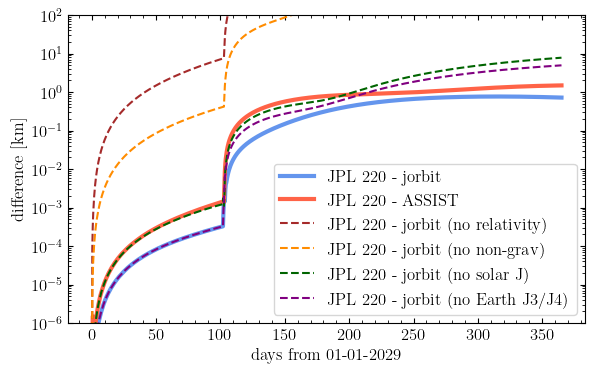

In [7]:
fig, ax = plt.subplots(figsize=(20/3, 4))
ax.plot(
    times.tdb.jd - times[0].tdb.jd,
    jnp.linalg.norm(jorb_xs - jpl_220_xs, axis=1) * u.au.to(u.km),
    label="JPL 220 - jorbit",
    color="cornflowerblue",
    lw=3
)
ax.plot(
    times.tdb.jd - times[0].tdb.jd,
    jnp.linalg.norm(assist_xs - jpl_220_xs, axis=1) * u.au.to(u.km),
    label="JPL 220 - ASSIST",
    color="tomato",
    lw=3
)
ax.plot(
    times.tdb.jd - times[0].tdb.jd,
    jnp.linalg.norm(jorb_xs_no_relativity - jpl_220_xs, axis=1) * u.au.to(u.km),
    label="JPL 220 - jorbit (no relativity)",
    color="brown",
    ls="--"
)
ax.plot(
    times.tdb.jd - times[0].tdb.jd,
    jnp.linalg.norm(jorb_xs_no_nongrav - jpl_220_xs, axis=1) * u.au.to(u.km),
    label="JPL 220 - jorbit (no non-grav)",
    color="darkorange",
    ls="--"
)
ax.plot(
    times.tdb.jd - times[0].tdb.jd,
    jnp.linalg.norm(jorb_xs_no_solar_j - jpl_220_xs, axis=1) * u.au.to(u.km),
    label="JPL 220 - jorbit (no solar J)",
    color="darkgreen",
    ls="--"
)
ax.plot(
    times.tdb.jd - times[0].tdb.jd,
    jnp.linalg.norm(jorb_xs_no_earth_j3_j4 - jpl_220_xs, axis=1) * u.au.to(u.km),
    label="JPL 220 - jorbit (no Earth J3/J4)",
    color="purple",
    ls="--"
)
ax.set(yscale="log", ylim=(1e-6, 1e2))
ax.tick_params(axis='both', labelsize=12)
ax.set_xlabel("days from 01-01-2029", fontsize=12)
ax.set_ylabel("difference [km]", fontsize=12)
ax.legend(fontsize=12)
plt.savefig("figures/apophis.pdf", bbox_inches="tight")

In [26]:
jnp.max(jnp.linalg.norm(jorb_xs - jpl_220_xs, axis=1) * u.au.to(u.km)), jnp.max(jnp.linalg.norm(assist_xs - jpl_220_xs, axis=1) * u.au.to(u.km))

(Array(0.76659645, dtype=float64), Array(1.48907348, dtype=float64))